# Cactus Identification: A Walkthrough from CNN to Transfer Learning with Pre-Trained Model VGG16

This project was my introduction to the world of Computer Vision using Deep Learning. In this write-up, I will do a walkthrough of the whole classifier making process, including:<br>

* Data preprocessing<br>
* Build a Convolutional Neural Network <br>
* Evaluate the model<br>
* Make tweaks to improve performance: data augmentation, progressive resizing<br>
* Apply transfer learning with a pre-trained model (VGG16)<br>
* Test the model by making prediction on first 10 images from the test set<br>
* Experiment with interactive testing using OpenCV

# Data Description

[This dataset](https://www.kaggle.com/c/aerial-cactus-identification/data) contains a large number of 32 x 32 thumbnail images containing aerial photos of a columnar cactus (Neobuxbaumia tetetzo). The file name of an image corresponds to its id.

I will attempt to create a classifier capable of predicting whether an images contains a cactus.

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code"></form>''')

In [2]:
# import necessary tools
import numpy as np
import pandas as pd
import tensorflow as tf
import os, cv2
from IPython.display import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras import layers, models
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Flatten, Activation, Dropout, MaxPooling3D

Using TensorFlow backend.


# Load the Data

In [3]:
train_dir = "train"
test_dir = "test"

train = pd.read_csv('train.csv')
test = pd.read_csv('sample_submission.csv')

# Data Overview

## Train Dataset

In [4]:
train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17500 entries, 0 to 17499
Data columns (total 2 columns):
id            17500 non-null object
has_cactus    17500 non-null int64
dtypes: int64(1), object(1)
memory usage: 273.5+ KB


In [6]:
print('Our train dataset has {} rows and {} columns.'.format(train.shape[0], train.shape[1]))

Our train dataset has 17500 rows and 2 columns.


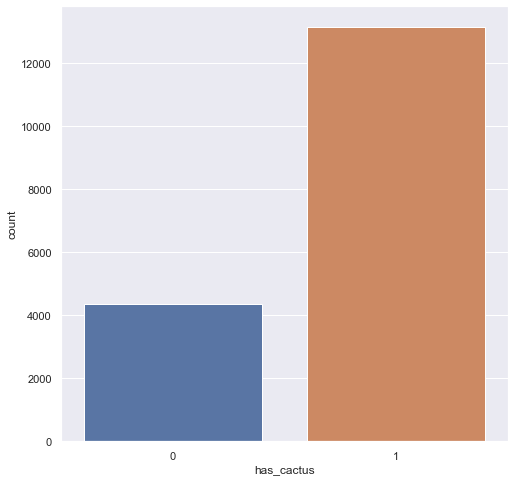

In [7]:
sns.set(rc={'figure.figsize':(8, 8)})
sns.countplot(x='has_cactus', data=train)

In [8]:
train['has_cactus'] = train['has_cactus'].astype(str)

## Test Dataset

In [9]:
test.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [10]:
test['has_cactus'] = test['has_cactus'].astype(str)

In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
id            4000 non-null object
has_cactus    4000 non-null object
dtypes: object(2)
memory usage: 62.6+ KB


In [12]:
print('Our test dataset has {} rows and {} columns.'.format(test.shape[0], test.shape[1]))

Our test dataset has 4000 rows and 2 columns.


## Visualize Images

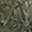

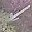

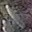

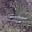

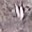

In [13]:
n_train = len(os.listdir(train_dir))
sample_idxs = np.random.choice(n_train, 5, replace=False)

for idx in sample_idxs:
    
    # Choose a random file from the training data directory.
    filename = os.listdir(train_dir)[idx]

    # Display the image contained in the chosen file.
    image = Image(os.path.join(train_dir, filename), width=250, height=250)
    display(image)

# Data Preprocessing

In [14]:
# specify batch_size
batch_size = 150

First, we create a data generator for the training dataset. In this data generator, we will:<br>
* rescale pixel values from [0, 255] to [0, 1]<br>
* perform image augmentation

In [15]:
# create data generator for the training data
train_datagen = ImageDataGenerator(rescale = 1./255,         # normalize pixel values to [0,1]
                                   rotation_range = 30,      # randomly applies rotations
                                   width_shift_range = 0.3,  # randomly applies width shifting
                                   height_shift_range = 0.3, # randomly applies height shifting
                                   horizontal_flip = True,   # randonly flips the image
                                   fill_mode = 'nearest')    # uses the fill mode nearest to fill gaps created

Then, we create a data generator for the test dataset. In this data generator, we will just rescale the pixel values.

In [16]:
# create data generator for the test data
validation_datagen = ImageDataGenerator(rescale=1./255)

Now we will apply .flow_from_dataframe() method to both data.

In [17]:
train_generator = train_datagen.flow_from_dataframe(dataframe=train[:15001],
                                                  directory=train_dir,
                                                  x_col='id', y_col='has_cactus',
                                                  class_mode='binary',
                                                  batch_size=batch_size,
                                                  target_size=(150,150))

validation_generator = validation_datagen.flow_from_dataframe(dataframe=train[15000:],
                                                            directory=train_dir,
                                                            x_col='id', y_col='has_cactus',
                                                            class_mode='binary',
                                                            batch_size=50,
                                                            target_size=(150,150))

Found 15001 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


# Model Building

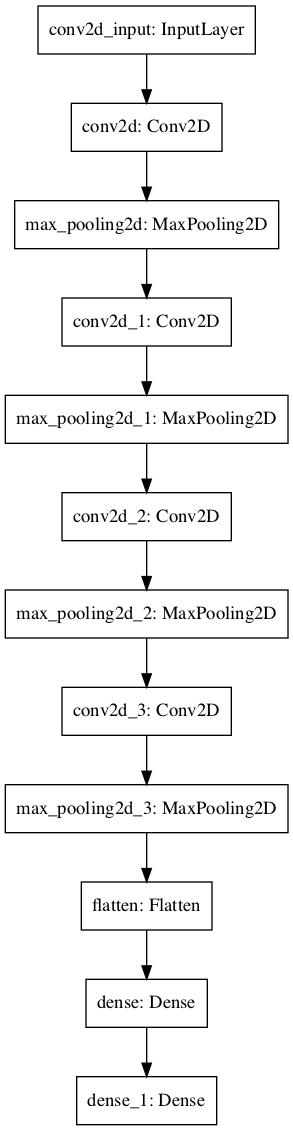

In [18]:
# visualize the model architecture
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model

model = models.Sequential()

model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

tf.keras.utils.plot_model(model, to_file='model_combined.png')

## Model Summary

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

## Model Compiling

We will use binary_crossentropy loss, Adam optimizer, and accuracy as metrics.

In [20]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

## Model Fitting

In [21]:
# create callbacks
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0,
                          patience = 3, 
                          verbose = 1,
                          restore_best_weights = True)

# put our callbacks into a callback list
callbacks = [earlystop]

In [22]:
epochs = 10
history = model.fit_generator(train_generator, 
                              steps_per_epoch=100, 
                              epochs=10, 
                              validation_data=validation_generator, 
                              validation_steps=50,
                              callbacks=callbacks)

Epoch 1/10


W0716 13:48:50.920698 4374977856 deprecation.py:323] From /Users/andreduong/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100/100 [==============================] - 420s 4s/step - loss: 0.3203 - acc: 0.8783 - val_loss: 0.3265 - val_acc: 0.9012
Epoch 2/10
100/100 [==============================] - 409s 4s/step - loss: 0.1712 - acc: 0.9436 - val_loss: 0.1348 - val_acc: 0.9428
Epoch 3/10
100/100 [==============================] - 411s 4s/step - loss: 0.1525 - acc: 0.9410 - val_loss: 0.1161 - val_acc: 0.9488
Epoch 4/10
100/100 [==============================] - 410s 4s/step - loss: 0.1513 - acc: 0.9418 - val_loss: 0.1287 - val_acc: 0.9452
Epoch 5/10
100/100 [==============================] - 409s 4s/step - loss: 0.1235 - acc: 0.9508 - val_loss: 0.1910 - val_acc: 0.9236
Epoch 6/10
100/100 [==============================] - 409s 4s/step - loss: 0.1224 - acc: 0.9498 - val_loss: 0.0974 - val_acc: 0.9564
Epoch 7/10
100/100 [==============================] - 411s 4s/step - loss: 0.0922 - acc: 0.9624 - val_loss: 0.2112 - val_acc: 0.9336
Epoch 8/10
100/100 [==============================] - 440s 4s/step - loss: 0.109

## Evaluating Our Model

### Train/Test Loss & Accuracy Graphs

To evaluate the model, we will plot the train/test loss and accuracy graphs using matplotlib/seaborn.

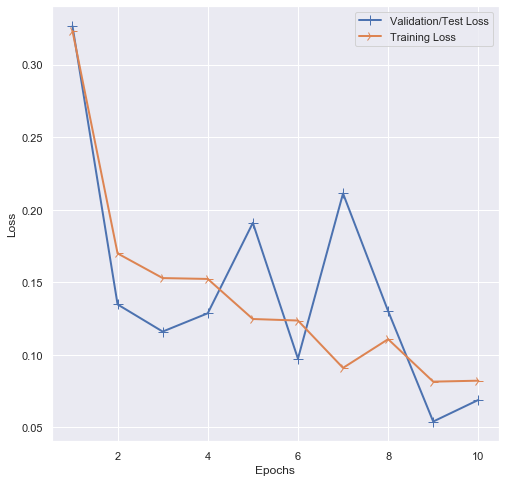

In [23]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

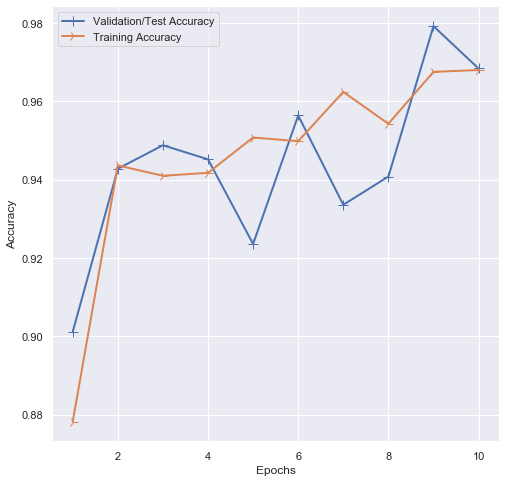

In [24]:
history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Transfer Learning with VGG16

## Can we speed the training process up? Let's try re-sizing the image to 64x64

First, we will load the pre-trained model. Freeze all layers except the top FC layers. Here's the model summary without the top layers:

In [14]:
# setting the input size now to 64 x 64 pixel 
img_rows = 64
img_cols = 64 

# load the pre-trained model
vgg16 = VGG16(weights='imagenet',input_shape = (img_rows, img_cols, 3), include_top=False)

# freeze the layers
for layer in vgg16.layers:
    layer.trainable = False
    
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

Now we apply transfer learning by adding the top FC layers.

Found 15001 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


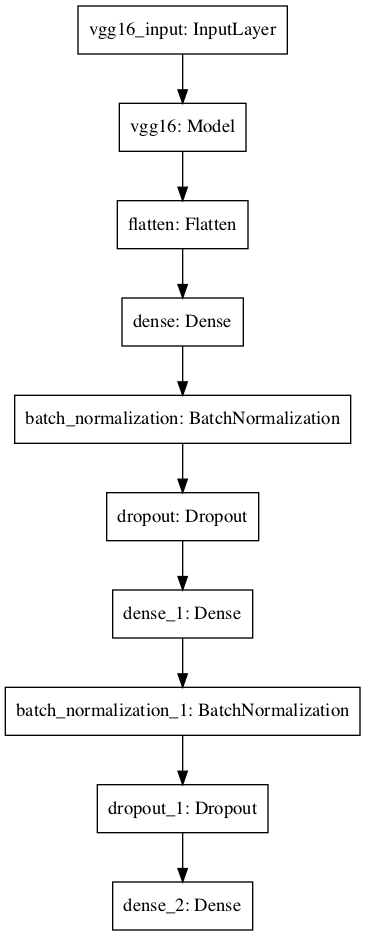

In [15]:
# create data generator for the training data
train_datagen = ImageDataGenerator(rescale = 1./255,         # normalize pixel values to [0,1]
                                   rotation_range = 30,      # randomly applies rotations
                                   width_shift_range = 0.3,  # randomly applies width shifting
                                   height_shift_range = 0.3, # randomly applies height shifting
                                   horizontal_flip = True,   # randonly flips the image
                                   fill_mode = 'nearest')    # uses the fill mode nearest to fill gaps created
 
validation_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_dataframe(dataframe=train[:15001],
                                                    directory=train_dir,
                                                    x_col='id', y_col='has_cactus',
                                                    class_mode='binary',
                                                    batch_size=32,
                                                    target_size=(img_rows, img_cols))

validation_generator = validation_datagen.flow_from_dataframe(dataframe=train[15000:],
                                                              directory=train_dir,
                                                              x_col='id', y_col='has_cactus',
                                                              class_mode='binary',
                                                              batch_size=32,
                                                              target_size=(img_rows, img_cols))


# re-loads the VGG16 model without the top or FC layers
vgg16 = VGG16(weights = 'imagenet', 
              include_top = False, 
              input_shape = (img_rows, img_cols, 3))

# freeze layers
for layer in vgg16.layers:
    layer.trainable = False


# create the combined model
vgg_model = models.Sequential()

vgg_model.add(vgg16)

vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation = 'relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(128, activation = 'relu'))
vgg_model.add(BatchNormalization())
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation = 'sigmoid'))

tf.keras.utils.plot_model(vgg_model, to_file='model_combined_vgg.png')

In [16]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               5

In [17]:
# compile the combined model
vgg_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

## Model Fitting

In [18]:
# create callbacks
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0,
                          patience = 3, 
                          verbose = 1,
                          restore_best_weights = True)

# put our callbacks into a callback list
callbacks = [earlystop]

# fit the model
epochs = 30
history = vgg_model.fit_generator(train_generator, 
                                  steps_per_epoch=100, 
                                  epochs=20, 
                                  validation_data=validation_generator, 
                                  validation_steps=50,
                                  callbacks=callbacks)

Epoch 1/20


W0716 16:25:25.413581 4391181632 deprecation.py:323] From /Users/andreduong/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


100/100 [==============================] - 118s 1s/step - loss: 0.4256 - acc: 0.8252 - val_loss: 0.1497 - val_acc: 0.9631
Epoch 2/20
100/100 [==============================] - 123s 1s/step - loss: 0.2535 - acc: 0.9078 - val_loss: 0.1314 - val_acc: 0.9625
Epoch 3/20
100/100 [==============================] - 119s 1s/step - loss: 0.2284 - acc: 0.9128 - val_loss: 0.1405 - val_acc: 0.9513
Epoch 4/20
100/100 [==============================] - 131s 1s/step - loss: 0.1842 - acc: 0.9362 - val_loss: 0.0907 - val_acc: 0.9656
Epoch 5/20
100/100 [==============================] - 123s 1s/step - loss: 0.1945 - acc: 0.9247 - val_loss: 0.0683 - val_acc: 0.9744
Epoch 6/20
100/100 [==============================] - 119s 1s/step - loss: 0.1528 - acc: 0.9441 - val_loss: 0.0695 - val_acc: 0.9744
Epoch 7/20
100/100 [==============================] - 149s 1s/step - loss: 0.1537 - acc: 0.9459 - val_loss: 0.1023 - val_acc: 0.9613
Epoch 8/20
100/100 [==============================] - 124s 1s/step - loss: 0.153

## Evaluating Our New Model

### Train/Test Loss & Accuracy Graphs

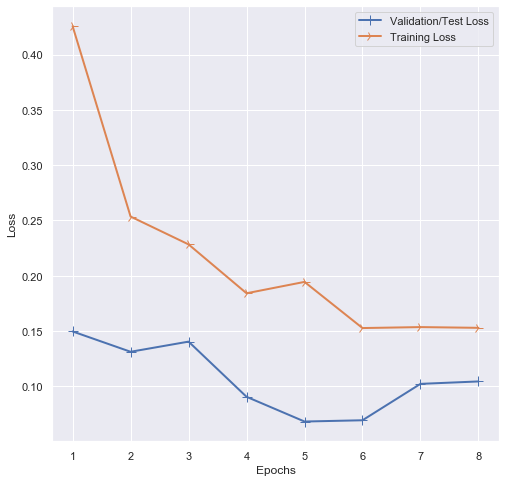

In [19]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

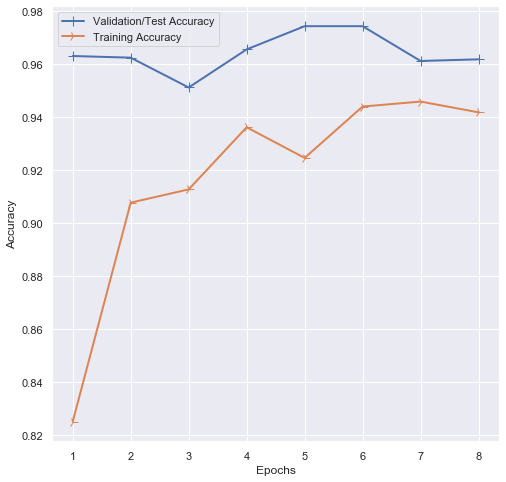

In [20]:
history_dict = history.history

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label='Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label='Training Accuracy')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Save Model for Later Deployment

In [23]:
vgg_model.save("./trained-models/cactus-vgg16.h5")

# Test Our Model

In this section, we will write a Python script to test our model by making prediction on the first 10 images of the test set.

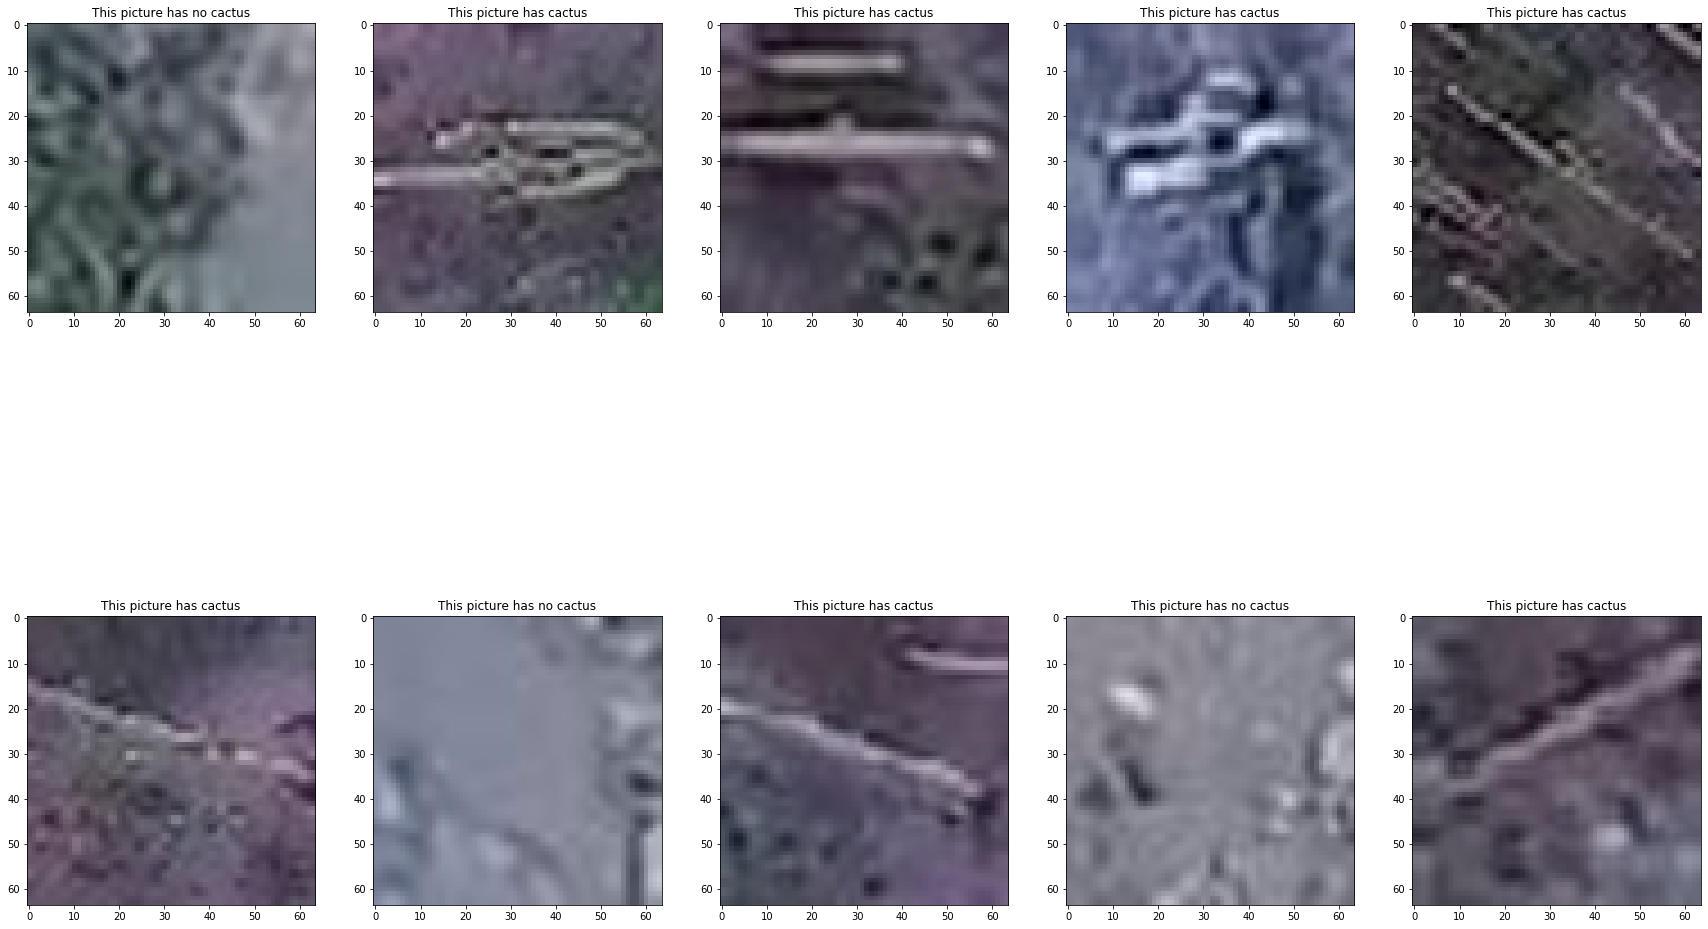

In [28]:
# import necessary tools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

model = load_model("./trained-models/cactus-vgg16.h5")
test_dir = "test"
nrows = 64
ncolumns = 64
columns = 5

test_imgs = ['./test/{}'.format(i) for i in os.listdir(test_dir)] # get test images

def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        # get the labels
        if 'cactus' in image:
            y.append(1)
        elif 'no cactus' in image:
            y.append(0)
    
    return X, y


X_test, y_test = read_and_process_image(test_imgs[0:10]) # Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

i = 0
text_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('has cactus')
    else:
        text_labels.append('has no cactus')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This picture ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

# Interactive Testing With OpenCV

In [16]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join
import re

model = load_model("./trained-models/cactus-vgg16.h5")

def draw_test(name, pred, im, true_label):
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 160, 0, 0, 500 ,cv2.BORDER_CONSTANT, value=BLACK)
    cv2.putText(expanded_image, "predited - " + pred, (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    cv2.putText(expanded_image, "true - " + true_label, (20, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.imshow(name, expanded_image)

def getRandomImage(path, img_width, img_height):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0, len(folders))
    path_class = folders[random_directory]
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    final_path = file_path + "/" + image_name
    return image.load_img(final_path, target_size = (img_width, img_height)), final_path, path_class

# dimensions of our images
img_width, img_height = 32, 32


files = []
predictions = []
true_labels = []
# predicting images
for i in range(0, 10):
    path = './test/' 
    img, final_path, true_label = getRandomImage(path, img_width, img_height)
    files.append(final_path)
    true_labels.append(true_label)
    x = image.img_to_array(img)
    x = x * 1./255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict_classes(images, batch_size = 10)
    predictions.append(classes)
    
for i in range(0, len(files)):
    image = cv2.imread((files[i]))
    draw_test("Prediction", class_labels[predictions[i][0]], image, true_labels[i])
    cv2.waitKey(0)

cv2.destroyAllWindows()